In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import random
import numpy as np

In [3]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

# Upload the dataset 
https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.tsv to test.tsv
Saving valid.tsv to valid.tsv
Saving train.tsv to train.tsv
User uploaded file "test.tsv" with length 301118 bytes
User uploaded file "valid.tsv" with length 301556 bytes
User uploaded file "train.tsv" with length 2408165 bytes


# Read in the data

In [7]:
import pandas as pd

In [8]:
train_data = pd.read_csv('./train.tsv', sep='\t', header=None).fillna('')
valid_data = pd.read_csv('./valid.tsv', sep='\t', header=None).fillna('')
test_data = pd.read_csv('./test.tsv', sep='\t', header=None).fillna('')
valid_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,,,none,11,43,8,5,105,
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


# Error Analysis with baseline model

Error analysis: Does the project provide a thoughtful error analysis, which looks for **linguistic patterns** in the **types of errors** made by the system(s) evaluated and sheds light on either **avenues for future work or the source of the strengths/weaknesses** of the systems?


A good error analysis tells us something about **why method X is effective or ineffective for problem Y**. This in turn provides a much richer starting point for further research, allowing us to go beyond throwing learning algorithms at the wall of tasks and seeing which stick, while allowing us to also discover which are the harder parts of a problem. 

Error analysis involves **examining the errors made by a system and developing a classification of them**. (This is typically best done over dev data, to avoid compromising held-out test sets.) At a superficial level, this can involve breaking things down by input length, token frequency or looking at confusion matrices. But we should not limit ourselves to examining only labels (rather than input linguistic forms) as with confusion matrices, or superficial properties of the linguistic signal. Languages are, after all, complex systems and linguistic forms are structured. So a deeper error analysis involves examining those linguistic forms and looking for patterns. 

Source : http://coling2018.org/error-analysis-in-research-and-writing/

Error analysis — the attempt to *analyze when, how, and why machine-learning models fail* — is a crucial part of the development cycle: **Researchers use it to suggest directions for future improvement, and practitioners make deployment decisions based on it. Since error analysis profoundly determines the direction of subsequent actions, we cannot afford it to be biased or incomplete.**



![title](https://miro.medium.com/max/1400/1*r4RwXFD0vnNl5VNLin_4Zw.png)

Source https://medium.com/@uwdata/errudite-55d5fbf3232e

Error Analysis can include **everything that helps you understand how the model behaves**, what are it's strengths and weaknesses. 

When having **access to the model's decisions**, e.g. weights for each n-gram, and they are easily understandable, we say that the model is **interpretable by design** ([Chapter 4, Interpretable Models](https://christophm.github.io/interpretable-ml-book/simple.html)) For such models, we can explore what the model chose as important features and use that in our analysis.

## TF-IDF scores of words

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [14]:
vectorizer = TfidfVectorizer(max_features=10000)
features = vectorizer.fit_transform(train_data.values[:, 2])
# the raw/textual n-grams the vectorizer is using
feature_array = np.array(vectorizer.get_feature_names())
# TF-IDF scores of the words in each instance of the input datasets
tfidf_sorting = np.argsort(features.toarray()).flatten()[::-1]

# With a TF-IDF Vecotrizer, we can already tell the words that have high TF-IDF scores
# Even before feeding them to the model:
# Look-up of the top-n words at the indices with 1) highest and 2) lowest scores 
print(feature_array[tfidf_sorting][:n])
print(feature_array[tfidf_sorting][-n:])

['veterans' 'manual' 'encouraging' 'stuff' 'you' 'telling' 'affairs'
 'value' 'commit' 'suicide']
['price' 'previously' 'previous' 'prevents' 'preventive' 'prevention'
 'preventing' 'prevented' 'preventative' '00']


In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
features = vectorizer.fit_transform(train_data.values[:, 2])
# training a linear model, which is interpretable by design
svc = SVC(kernel='linear', verbose=True, random_state=0, probability=True)
svc.fit(features, train_data.values[:, 1])

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=True)

## Detailed Classification Performance
Looking at the **classification report and the confusion matrix** is the most basic step of performing error analysis - you can find which classes are confused with which other classes most often and compare the performance of the different classes.

In [17]:
features_valid = vectorizer.transform(valid_data.values[:, 2])
valid_pred = svc.predict(features_valid)

print(classification_report(valid_data.values[:, 1], valid_pred))
confusion_matrix(valid_data.values[:, 1], valid_pred)

              precision    recall  f1-score   support

 barely-true       0.20      0.16      0.18       237
       false       0.26      0.32      0.29       263
   half-true       0.26      0.34      0.29       248
 mostly-true       0.28      0.27      0.28       251
  pants-fire       0.45      0.11      0.18       116
        true       0.19      0.20      0.19       169

    accuracy                           0.25      1284
   macro avg       0.27      0.23      0.24      1284
weighted avg       0.26      0.25      0.25      1284



array([[38, 62, 67, 40,  5, 25],
       [44, 85, 58, 37,  5, 34],
       [36, 64, 84, 35,  1, 28],
       [33, 47, 52, 69,  3, 47],
       [25, 39, 20, 12, 13,  7],
       [15, 27, 41, 51,  2, 33]])

Can you spot any insights?

In [19]:
print(len(vectorizer.vocabulary_))
print(vectorizer.get_feature_names())
print(svc.classes_)

10000
['000', '000 americans', '000 and', '000 children', '000 fewer', '000 for', '000 from', '000 in', '000 jobs', '000 jobs and', '000 jobs in', '000 more', '000 new', '000 new jobs', '000 new private', '000 of', '000 on', '000 people', '000 per', '000 per year', '000 students', '000 tax', '000 teachers', '000 to', '000 to the', '000 troops', '000 year', '10', '10 000', '10 10', '10 billion', '10 in', '10 million', '10 percent', '10 percent of', '10 years', '100', '100 000', '100 000 people', '100 billion', '100 million', '100 million in', '100 percent', '100 percent of', '100 years', '10th', '11', '11 percent', '110', '115', '12', '12 000', '12 education', '12 million', '12 percent', '12 years', '120', '120 000', '125', '13', '13 000', '13 percent', '13 state', '13 state budget', '130', '130 000', '14', '14 000', '14 billion', '14 percent', '140', '15', '15 000', '15 billion', '15 million', '15 percent', '15 percent of', '15 years', '150', '150 000', '150 billion', '150 million', '1

## Model's Feature Weights

We can now see what are the most importand words for each class by looking at the weights the model assigned to each feature in the input.

barely-true


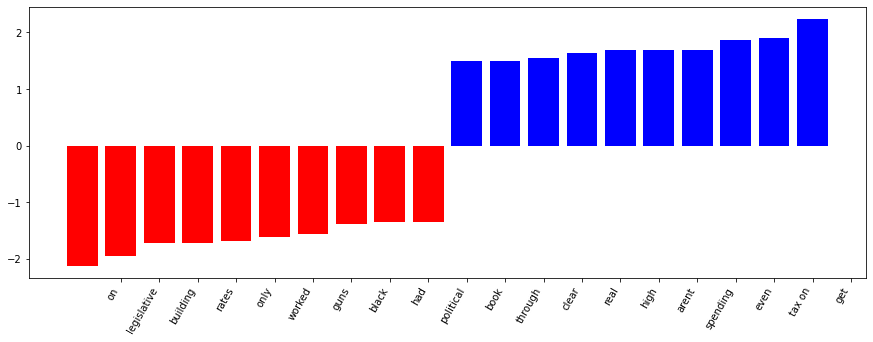

false


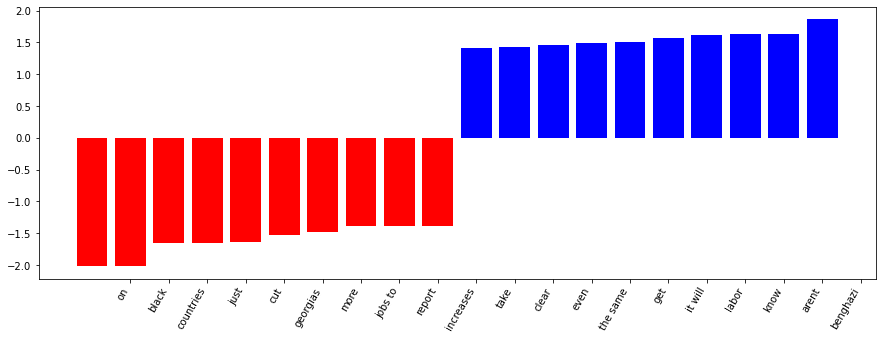

half-true


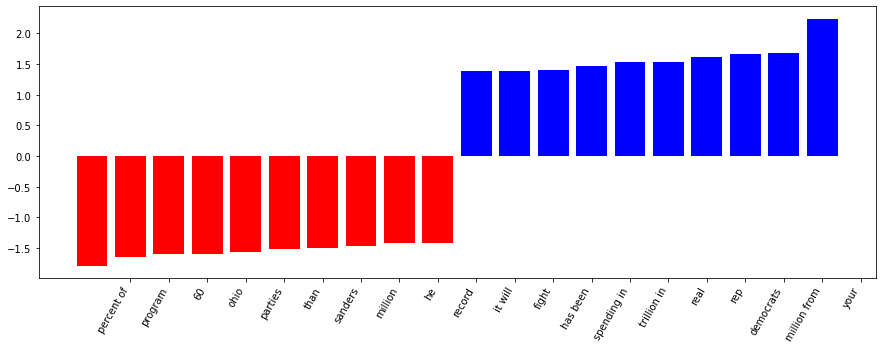

mostly-true


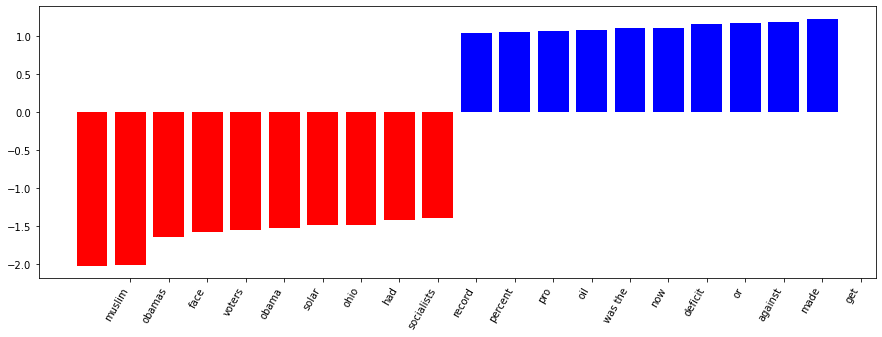

pants-fire


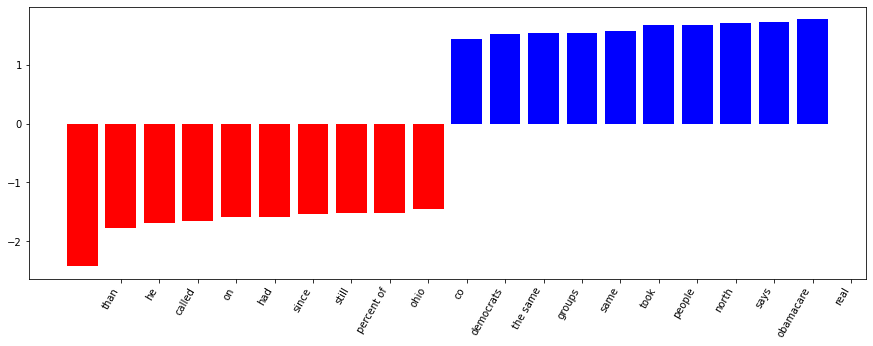

true


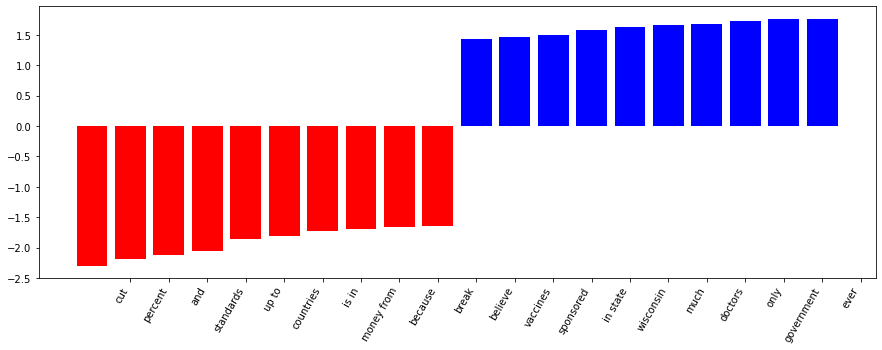

In [23]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = svc.coef_.toarray()

for i, cls in enumerate(svc.classes_): # for each of the classes
  print(cls)
  # get the weights for the class
  coef = all_class_coef[i]
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = vectorizer.get_feature_names()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

## Error classification 

We can now look at the predictions of the model to try and spot any problems or particular features of the model. 

We will look at instances the model classifies **in/correctly**, which in turn can be broken down to: **instances with high/ low/ medium confidence**. To do that, we'll use the **probability/confidence** of the model's prediction, which is available for all ML models.

In [24]:
# get the probability of the model
valid_pred_prob = svc.predict_proba(features_valid)

In [25]:
from collections import defaultdict

# collect correct and wrong predictions, keeping the confidence of the prediction
errors = defaultdict(lambda: [])
correct_preds = defaultdict(lambda: [])

for (i, instance), pred, pred_score in zip(valid_data.iterrows(), valid_pred, valid_pred_prob):
  # get the index/id of the gold class in the probability array (n_classes x 1)
  index_of_class = np.where(svc.classes_ == instance[1])
  # get the index/id of the predicted class in the probability array (n_classes x 1)
  index_of_pred_class =  np.where(svc.classes_ == pred)
  # depending on whether the prediction is correct, collect the instances as errors or correct predictions
  if pred != instance[1]:
    errors[instance[1]].append((instance[2], pred_score[index_of_class], pred_score[index_of_pred_class], pred))
  else:
    correct_preds[instance[1]].append((instance[2], pred_score[index_of_class], pred_score, pred))

In [26]:
import pprint

for cls in svc.classes_:
  print(cls)
  print('High probability for correct class')
  # sort the errors by the probability of the gold class and look at the:
  # 1. instances where the gold class had a high probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[-10:])
  print('Low probability for correct class')
  # 1. instances where the gold class had a low probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[:10])

barely-true
High probability for correct class
[('Says Gina Raimondos venture capital firm secured a secret no-bid contract '
  'funded by taxpayers.',
  array([0.21217546]),
  array([0.27254687]),
  'false'),
 ('Says Sen. JeanneShaheens wealth has surged while in public office.',
  array([0.21682284]),
  array([0.26791213]),
  'half-true'),
 ('Under Obamacare, when you turn Medicaid over to the states ... the money '
  'will be available up front for the expansion for a few years. Then, the '
  'money will go away.',
  array([0.21779982]),
  array([0.33887561]),
  'false'),
 ('Barack Obama and Joe Biden oppose new drilling at home and oppose nuclear '
  'power.',
  array([0.22056532]),
  array([0.22583221]),
  'half-true'),
 ('Rosalyn Dance voted against President Obamas Medicaid expansion.',
  array([0.22122473]),
  array([0.27035741]),
  'false'),
 ('SaysDavid Perdue made tens of millions of dollars piling a firm with '
  'billions in debt.',
  array([0.22193508]),
  array([0.309944

In [27]:
# We can check for some instances what were their TF-IDF scores (the input for the model)
text = 'Ken Lanci is a lifelong Clevelander'
print(vectorizer.transform([text]))
text = 'Ken Lanci is a lifelong Clevelander'
print([word for word in text.lower().split() if word in vectorizer.vocabulary_])

  (0, 4438)	0.934098676866197
  (0, 4173)	0.35701493228830095
['ken', 'is']


In [28]:
# do the same for correct predictions
for cls in svc.classes_:
  print(cls)
  print('High probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[-10:])
  print('Low probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[:10])

barely-true
High probability for correct class
[('Says that President Obama promised that with the stimulus plan, '
  'unemployment would never go above 8 percent. He even said it would be 6 '
  'percent by now.',
  array([0.25525044]),
  array([0.25525044, 0.19127102, 0.20330259, 0.16047221, 0.08753189,
       0.10217186]),
  'barely-true'),
 ('Mark Sharpe has lowered property taxes by 17 percent.',
  array([0.2638481]),
  array([0.2638481 , 0.10820738, 0.17193084, 0.19098211, 0.08364345,
       0.18138811]),
  'barely-true'),
 ('Says Hillary Clinton abided by the ethics agreement between the Clinton '
  'Foundation and the Obama administration.',
  array([0.27292566]),
  array([0.27292566, 0.15652994, 0.29347436, 0.12981635, 0.10054171,
       0.04671197]),
  'barely-true'),
 ('Michelle Nunn has praised the Occupy movement.',
  array([0.27348039]),
  array([0.27348039, 0.17874239, 0.20113334, 0.13100121, 0.09075219,
       0.12489048]),
  'barely-true'),
 ('Roughly 700 Georgians die 

# Error Analysis with a Transformer Model

## Learning Curves
Error analysis can start as early as fine-tuning the model. Observing different **learning curves** of the loss function of both the training and the development set can tell whether we need more data; we need a bigged dev set; we need a more complex model; whether the model is learning anything/overfitting, etc. 

http://mlwiki.org/index.php/Learning_Curves

https://medium.com/uwaterloo-voice/error-analysis-in-deep-learning-6df3b3d335af


Model Debugging can be made easy with external tools, too:

https://wandb.ai/latentspace/published-work/The-Science-of-Debugging-with-W&B-Reports--Vmlldzo4OTI3Ng

"Those who don't track training are doomed to repeat it."

In [29]:
!pip3 install transformers

     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 1.1MB 13.1MB/s 
     |████████████████████████████████| 890kB 28.2MB/s 
     |████████████████████████████████| 3.0MB 25.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e7943bac2abf2159fd4f061d2d97d1a9de22d10d389b63c9d895b0242141643e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [30]:
import torch
import random
import numpy as np
import pandas as pd

from functools import partial
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from typing import List, Tuple
from tqdm import tqdm_notebook as tqdm

In [31]:
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer
from transformers import RobertaConfig
from transformers import RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from typing import List, Tuple

In [32]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  losses_all = []
  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      attention_mask = batch[1]
      labels = batch[2]

      loss, logits = model(input_ids, attention_mask, labels=labels)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
      losses_all.append(loss.detach().cpu().numpy())
    acc = accuracy(logits_all, labels_all)

    return acc, np.mean(losses_all)

def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler = None
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for i, batch in tqdm(enumerate(train_dl)):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      attention_mask = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, attention_mask, labels=labels)
      wandb.log({'loss': loss.item()})
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
      # CHANGED CODE -- as the Transformer model trains for a few epoch, 
      # we might want to look at the learning curves each other step
      if i % 100 == 0:
        acc, val_loss = evaluate(model, valid_dl)
        wandb.log({'acc': acc, 'train_loss': np.mean(loss_epoch), 'val_loss': val_loss})

    # Perform inline evaluation at the end of the epoch
    acc, val_loss = evaluate(model, valid_dl)
    wandb.log({'acc': acc, 'train_loss': np.mean(loss_epoch), 'val_loss': val_loss})
    print(f'Validation accuracy: {acc}, train loss: {np.mean(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model')
      best_acc = acc
        #gc.collect()

  model.load_state_dict(best_model)
  return model, losses

In [33]:
def text_to_batch_transformer(text: List, tokenizer: PreTrainedTokenizer) -> Tuple[List, List]:
    """Turn a piece of text into a batch for transformer model

    :param text: The text to tokenize and encode
    :param tokenizer: The tokenizer to use
    :return: A list of IDs and a mask
    """
    input_ids = [tokenizer.encode(t, add_special_tokens=True, truncation=True) for t in text]

    masks = [[1] * len(i) for i in input_ids]

    return input_ids, masks

class ClassificationDatasetReader(Dataset):
  def __init__(self, df, tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.values[idx]
    # Calls the text_to_batch function
    input_ids, masks = text_to_batch_transformer([row[2]], self.tokenizer)
    label = label_map[row[1]]
    return input_ids, masks, label

In [34]:
label_map = {l:i for i,l in enumerate((set(train_data.values[:,1]) | set(valid_data.values[:,1]) | set(test_data.values[:,1])))}
num_labels = len(label_map)

print(label_map)

{'half-true': 0, 'false': 1, 'mostly-true': 2, 'barely-true': 3, 'pants-fire': 4, 'true': 5}


In [35]:
def collate_batch_transformer(pad_id, input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [i[0][0] for i in input_data]
    masks = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [pad_id] * (max_length - len(i))) for i in input_ids]
    masks = [(m + [pad_id] * (max_length - len(m))) for m in masks]

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(m) == max_length for m in masks))
    return torch.tensor(input_ids), torch.tensor(masks), torch.tensor(labels)

In [36]:
# a few steps needed to initialize the project in WANDB
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.7MB 4.5MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 122kB 29.6MB/s 
     |████████████████████████████████| 163kB 23.7MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [40]:
wandb.init(project="lab-5-bert",
           config={
               "batch_size": 8,
               "learning_rate": 5e-5,
               "dataset": "LIAR",
           })

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [51]:
weight_decay = 0.01
n_epochs = 2
lr = 3e-5

# Get the device
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
vocabulary = tokenizer.get_vocab()

# Create the dataset readers
train_dataset = ClassificationDatasetReader(train_data, tokenizer)
# dataset loaded lazily with N workers in parallel
collate_fn = partial(collate_batch_transformer, 0)
train_dl = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn, num_workers=8)

valid_dataset = ClassificationDatasetReader(valid_data, tokenizer)
valid_dl = DataLoader(valid_dataset, batch_size=6, collate_fn=collate_fn, num_workers=8)

config = RobertaConfig.from_pretrained('roberta-base', num_labels=6)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config).to(device)

# Create the optimizer
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    200,
    n_epochs * len(train_dl)
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [42]:
# magic to have plots of the learning curves
%%wandb

model, losses = train(model, train_dl, valid_dl, optimizer, 3, device, scheduler)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validation accuracy: 0.19314641744548286, train loss: 1.7675139008730423



Validation accuracy: 0.19314641744548286, train loss: 1.7607530861761254



Validation accuracy: 0.19314641744548286, train loss: 1.7559288084402236


## Visualization of Attention Weights with BertViz
https://github.com/jessevig/bertviz


## Interpretability methods

Transformer models and most of the NN approaches can't be as easily interpreted as simple models like LinearSVC. There we use tools like visualizing attention over the input words or other techniques to show which are the **salient features in the input**. One such tool is **Input X Gradient**, which looks at the gradient of the input w.r.t. to the output (for a particular class) and muliplies the input with the gradient to produce the saliency scores. Note that, the scores will be for the embedding layer as the input is non-differentiable and we'll have to aggregate them to arrive at scores per word.


In [43]:
!pip install captum

     |████████████████████████████████| 1.4MB 5.0MB/s 


In [52]:
model, losses = train(model, train_dl, valid_dl, optimizer, 1, device, scheduler)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validation accuracy: 0.18457943925233644, train loss: 1.7665707571295597


In [53]:
from captum.attr import InputXGradient, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

# we summarise with L2 norm the gradient for the embedding dimentions to arrive at one score per word
def summarize_attributions(attributions):
    attributions = attributions.norm(p=1, dim=-1).squeeze(0)
    return attributions

# we need a wrapper around the model as the tool needs a specific output format
class BertModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model

    def forward(self, input, attention_mask):
        return self.model(input, attention_mask=attention_mask)[0]


def get_model_embedding_emb(model):
    return model.bert.embeddings.embedding.word_embeddings


def generate_saliency(model, instance, collate_fn):
    model.train()
    ablator = InputXGradient(model)
    
    # COMPUTE SALIENCY
    embedding_layer_name = 'model.roberta.embeddings'
    # places a hook to extract the gradients for the embedding layer
    interpretable_embedding = configure_interpretable_embedding_layer(model, embedding_layer_name)

    inputs = tokenizer.encode_plus(instance, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids'].to(device)

    token_ids = input_ids.detach().cpu().numpy().tolist()
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    tokens = [tokenizer.decode([t]) for t in token_ids[0]]
    # provide saliency scores w.r.t. each class
    for cls_ in range(6):
        attributions = ablator.attribute(input_embeddings, 
                                         target=cls_, 
                                         additional_forward_args=(input_ids != tokenizer.pad_token_id))
        attributions = summarize_attributions(attributions,).detach().cpu().numpy().tolist()
        print(cls_)
        pprint.pprint([(token, f'{score:.2f}') for token, score in zip(tokens, attributions)])

    # IMPORTANT: remove the hook
    remove_interpretable_embedding_layer(model, interpretable_embedding)

In [54]:
model_wrapper = BertModelWrapper(model)
claim = 'Sen. Harry Reid voted against declaring English our national language, twice.'
generate_saliency(model_wrapper, claim, collate_batch_transformer)

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "
/usr/local/lib/python3.6/dist-packages/captum/attr/_utils/gradient.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by m

0
[('<s>', '0.00'),
 ('Sen', '0.00'),
 ('.', '0.00'),
 (' Harry', '0.00'),
 (' Reid', '0.00'),
 (' voted', '0.00'),
 (' against', '0.00'),
 (' declaring', '0.00'),
 (' English', '0.00'),
 (' our', '0.00'),
 (' national', '0.00'),
 (' language', '0.00'),
 (',', '0.00'),
 (' twice', '0.00'),
 ('.', '0.00'),
 ('</s>', '0.00')]
1
[('<s>', '0.00'),
 ('Sen', '0.00'),
 ('.', '0.00'),
 (' Harry', '0.00'),
 (' Reid', '0.00'),
 (' voted', '0.00'),
 (' against', '0.00'),
 (' declaring', '0.00'),
 (' English', '0.00'),
 (' our', '0.00'),
 (' national', '0.00'),
 (' language', '0.00'),
 (',', '0.00'),
 (' twice', '0.00'),
 ('.', '0.00'),
 ('</s>', '0.00')]
2
[('<s>', '0.00'),
 ('Sen', '0.00'),
 ('.', '0.00'),
 (' Harry', '0.00'),
 (' Reid', '0.00'),
 (' voted', '0.00'),
 (' against', '0.00'),
 (' declaring', '0.00'),
 (' English', '0.00'),
 (' our', '0.00'),
 (' national', '0.00'),
 (' language', '0.00'),
 (',', '0.00'),
 (' twice', '0.00'),
 ('.', '0.00'),
 ('</s>', '0.00')]
3
[('<s>', '0.00'),
 (

In [55]:
label_map

{'barely-true': 3,
 'false': 1,
 'half-true': 0,
 'mostly-true': 2,
 'pants-fire': 4,
 'true': 5}

Can you perform the same error analysis - classification report and observing errors/correct predictions and find patterns where RoBERTa does better?